In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
FROM_SCRATCH = True

9.1.1 Preparing the data.
We’re using the wine-quality dataset, a numeric tabular dataset containing features that refer to the chemical composition of wines and quality ratings. To make this a simple classification task, we bucket all wines with ratings greater
than five as good, and the rest we label bad. We also normalize all the features.

In [2]:
store = pd.read_csv('input/store.csv')
train = pd.read_csv('input/train.csv',parse_dates=[2])
test = pd.read_csv('input/test.csv',parse_dates=[3])
# fillna in store with 0 has better result than median()
# Aufbereiten der daten
store.fillna(0, inplace=True)
# fill missing values in test with 1
# Aufbereiten der Daten
test.fillna(value = 1, inplace = True)
# merge data with store
# Alles in eine Tabelle
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
# only use data of Sales>0 and Open is 1
train = train[(train.Open != 0)&(train.Sales >0)]

/var/folders/dq/dch41hs15kbc8_c2sx7kbn8r0000gn/T/ipykernel_84313/650215609.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('input/train.csv',parse_dates=[2])


In [3]:
# gibt erste 5 Zeilen aus
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


Text(0.5, 1.0, 'Store 10 Sales Distribution')

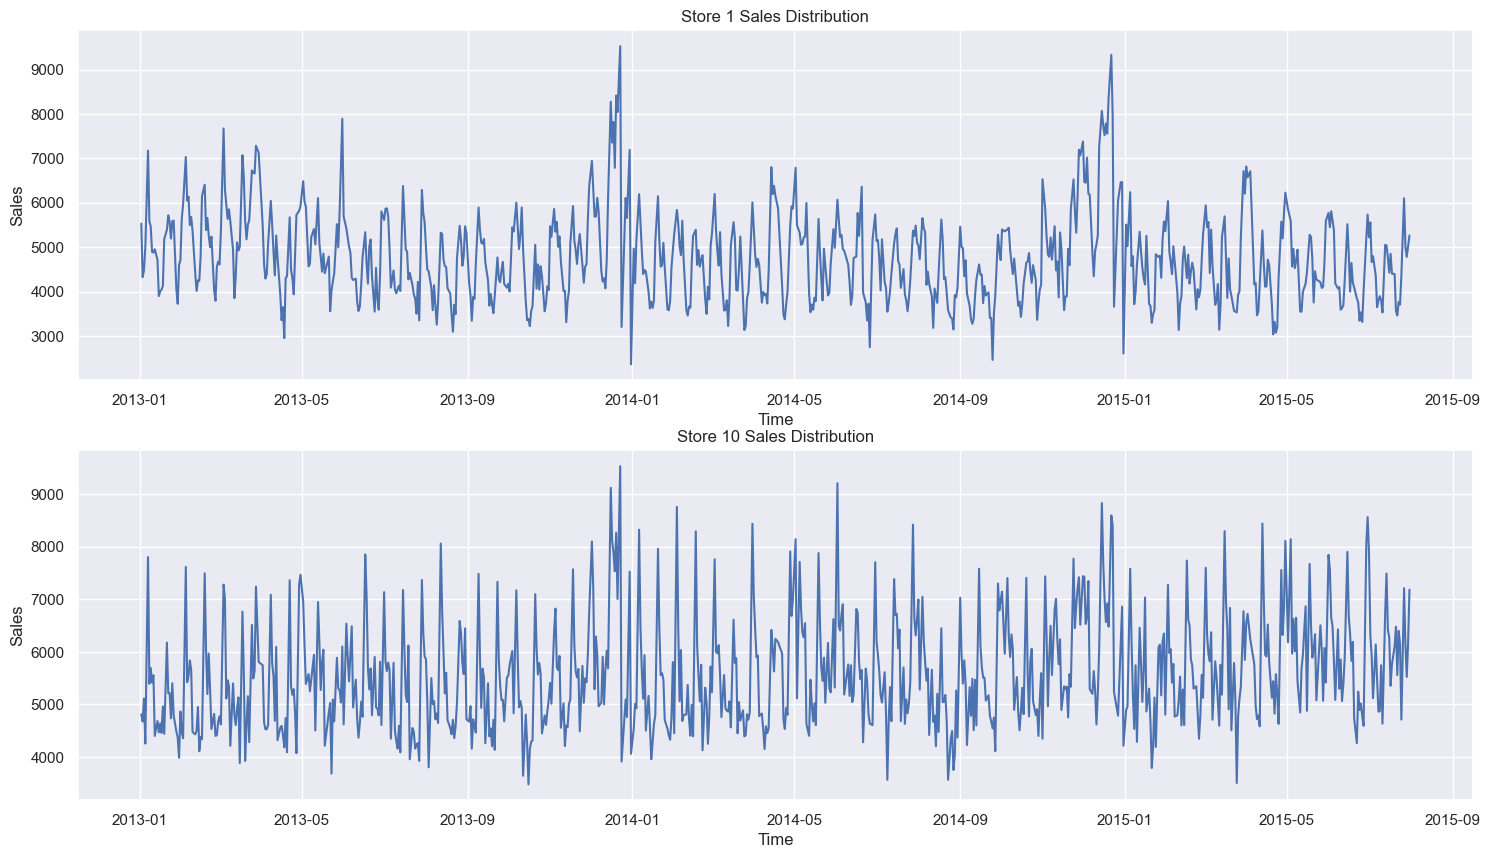

In [4]:
# zeichnet Verkuafsverteilung von Store 1 und 10 über den gesamten Zeitraum
import matplotlib.pyplot as plt
store_1 = train.loc[(train["Store"]==1)&(train['Sales']>0), ['Date',"Sales"]]
store_10 = train.loc[(train["Store"]==10)&(train['Sales']>0), ['Date',"Sales"]]
f = plt.figure(figsize=(18,10))
ax1 = f.add_subplot(211)
ax1.plot(store_1['Date'], store_1['Sales'], '-')
ax1.set_xlabel('Time')
ax1.set_ylabel('Sales')
ax1.set_title('Store 1 Sales Distribution')

ax2 = f.add_subplot(212)
ax2.plot(store_10['Date'], store_10['Sales'], '-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Sales')
ax2.set_title('Store 10 Sales Distribution')

Text(0.5, 1.0, 'Store Daily Open Countplot')

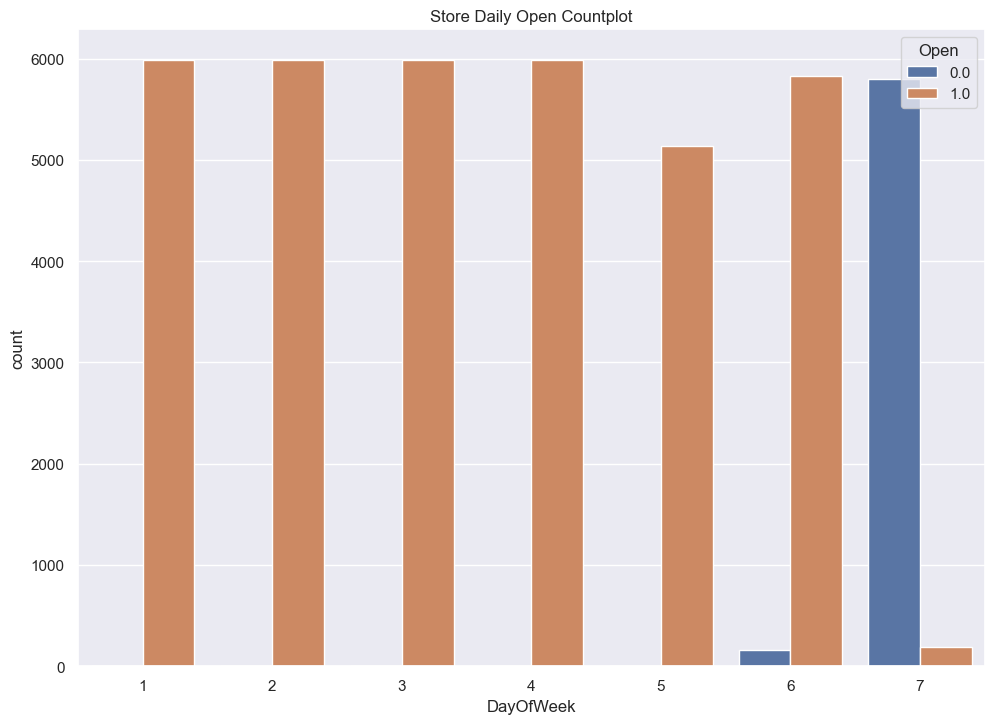

In [5]:
# zeigt Öffnungszeiten-Verteilung der Stores an allen Tagen an
import seaborn as sns
sns.countplot(x = 'DayOfWeek', hue = 'Open', data = test)
plt.title('Store Daily Open Countplot')

/var/folders/dq/dch41hs15kbc8_c2sx7kbn8r0000gn/T/ipykernel_84313/1108454165.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g1 = sns.distplot(train['Sales'],hist = True,label='skewness:{:.2f}'.format(train['Sales'].skew()),ax = ax1)
/var/folders/dq/dch41hs15kbc8_c2sx7kbn8r0000gn/T/ipykernel_84313/1108454165.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/

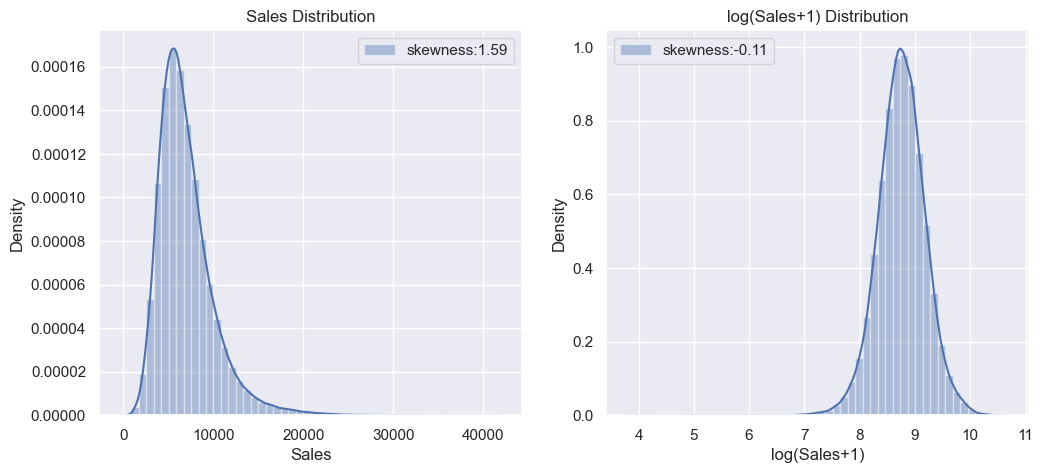

In [6]:
# Dichteverteilung der Verkaufszahlen. Einmal normal und einmal logarithmisch und normalisiert
import seaborn as sns
import matplotlib.pyplot as plt

# plotten der Verteilung der Verkäufe aller Stores der Trainingsdaten
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
g1 = sns.distplot(train['Sales'],hist = True,label='skewness:{:.2f}'.format(train['Sales'].skew()),ax = ax1)
g1.legend()
g1.set(xlabel = 'Sales', ylabel = 'Density', title = 'Sales Distribution')
g2 = sns.distplot(np.log1p(train['Sales']),hist = True,label='skewness:{:.2f}'.format(np.log1p(train['Sales']).skew()),ax=ax2)
g2.legend()
g2.set(xlabel = 'log(Sales+1)',ylabel = 'Density', title = 'log(Sales+1) Distribution')
plt.show()

In [7]:
nQ = 5
# neue Spalte 'Class' hinzugefügt
train['Class'] = 0
classes = np.arange(0,nQ+1)

#  Quantile für alle Tage
quantile = np.arange(1, nQ) / nQ
store_quan = np.arange(0, nQ+2)
store_quan[0] = -1
store_quan[1] = 1
# Quantile berechnet und max am Ende des Arrays gespeichert
for index, x in enumerate(quantile):
    store_quan[index+2] = train['Sales'].quantile(x)
store_quan[nQ+1] = train['Sales'].max()

"""
#  Quantil für verkaufsoffene Sonntage
store_df_day = train.loc[(train['DayOfWeek']== 7) & (train['Open'] == 1)]
quantile = np.arange(1, nQ) / nQ
store_quan_Sun = np.arange(0, nQ+2)
store_quan_Sun[0] = -1
store_quan_Sun[1] = 1
for index, x in enumerate(quantile):
    store_quan_Sun[index+2] = store_df_day['Sales'].quantile(x)
store_quan_Sun[nQ+1] = store_df_day['Sales'].max()

# Spezifische Quantile für jeden Tag und jeden Store
store_quan = np.zeros((train['Store'].max(), 7, nQ+2))
for Id in train['Store'].unique():
    store_df = train[train['Store'] == Id]
    for DayOfWeek in  store_df['DayOfWeek'].unique():
        if DayOfWeek != 7:
            store_df_day = store_df.loc[(store_df['DayOfWeek']== DayOfWeek) & (store_df['Open'] == 1)]
            quantile = np.arange(1, nQ) / nQ
            store_quan[Id-1][DayOfWeek-1][0] = -1
            store_quan[Id-1][DayOfWeek-1][1] = 1
            for index, x in enumerate(quantile):
                store_quan[Id-1][DayOfWeek-1][index+2] = store_df_day['Sales'].quantile(x)
            store_quan[Id-1][DayOfWeek-1][nQ+1] = store_df_day['Sales'].max()
        else:
            store_quan[Id-1][DayOfWeek-1] = store_quan_Sun
#"""

"\n#  Quantil für verkaufsoffene Sonntage\nstore_df_day = train.loc[(train['DayOfWeek']== 7) & (train['Open'] == 1)]\nquantile = np.arange(1, nQ) / nQ\nstore_quan_Sun = np.arange(0, nQ+2)\nstore_quan_Sun[0] = -1\nstore_quan_Sun[1] = 1\nfor index, x in enumerate(quantile):\n    store_quan_Sun[index+2] = store_df_day['Sales'].quantile(x)\nstore_quan_Sun[nQ+1] = store_df_day['Sales'].max()\n\n# Spezifische Quantile für jeden Tag und jeden Store\nstore_quan = np.zeros((train['Store'].max(), 7, nQ+2))\nfor Id in train['Store'].unique():\n    store_df = train[train['Store'] == Id]\n    for DayOfWeek in  store_df['DayOfWeek'].unique():\n        if DayOfWeek != 7:\n            store_df_day = store_df.loc[(store_df['DayOfWeek']== DayOfWeek) & (store_df['Open'] == 1)]\n            quantile = np.arange(1, nQ) / nQ\n            store_quan[Id-1][DayOfWeek-1][0] = -1\n            store_quan[Id-1][DayOfWeek-1][1] = 1\n            for index, x in enumerate(quantile):\n                store_quan[Id-1][

In [8]:
print(store_quan)

[   -1     1  4537  5758  7056  8958 41551]


In [9]:
# process train and test
# aufbereiten der daten, neue Spalten und manche werden entfernt
def process(data, isTest = False):
    # label encode some features
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    # buchstaben zu zahlen
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    # extract some features from date column
    data['Month'] = data.Date.dt.month
    data['Year'] = data.Date.dt.year
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear

    # calculate competiter open time in months
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)

    # calculate promo2 open time in months
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)

    # Indicate whether the month is in promo interval
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['month_str'] = data.Month.map(month2str)

    # schaut ob Monat ein Promomonat ist
    def check(row):
        if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
            return 1
        else:
            return 0
    # wenn ja dann hinzugefügt
    data['IsPromoMonth'] =  data.apply(lambda row: check(row),axis=1)

    # select the features we need
    features = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']

    # wenn kein Test dann hinzufügen von Sales
    if not isTest:
        features.append('Sales')

    data = data[features]
    return data

train = train.sort_values(['Date'],ascending = False)
train = process(train)
test = process(test,isTest = True)

/var/folders/dq/dch41hs15kbc8_c2sx7kbn8r0000gn/T/ipykernel_84313/3347806817.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['WeekOfYear'] = data.Date.dt.weekofyear
/var/folders/dq/dch41hs15kbc8_c2sx7kbn8r0000gn/T/ipykernel_84313/3347806817.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['WeekOfYear'] = data.Date.dt.weekofyear


In [10]:
# erste 5 zeilen von testdaten ausgeben
test.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
0,1,4,1,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,9,17,38,84.0,24189.50,0
1,1,3,1,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,9,16,38,84.0,24189.50,0
2,1,2,1,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,9,15,38,84.0,24189.50,0
3,1,1,1,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,9,14,38,84.0,24189.50,0
4,1,7,0,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,9,13,37,84.0,24189.25,0


In [11]:
# erste 5 zeilen von trainingsdaten ausgeben
train.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales
0,1,5,1,0,1,3,1,1270.0,9.0,2008.0,...,0.0,0.0,2015,7,31,31,82.0,24187.75,0,5263
146142,162,5,1,0,1,4,3,5340.0,3.0,2012.0,...,13.0,2010.0,2015,7,31,31,40.0,64.50,1,10735
143500,159,5,1,0,0,4,1,8530.0,3.0,2013.0,...,0.0,0.0,2015,7,31,31,28.0,24187.75,0,9758
709530,780,5,1,0,1,1,1,18160.0,0.0,0.0,...,0.0,0.0,2015,7,31,31,24187.0,24187.75,0,7834
144258,160,5,1,0,1,4,3,17110.0,11.0,2005.0,...,0.0,0.0,2015,7,31,31,116.0,24187.75,0,7839


In [12]:
# Liste mit den Features
featuresR  = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']
# Features zu Arrays
train_data = train[featuresR].to_numpy()
test_data = test[featuresR].to_numpy()
labels_train = train[['Sales']].to_numpy()
labels_train = np.log1p(labels_train)

# Daten aufteilen in Test und Trainingsdaten, skalieren der Daten und Schätzer berechnen
X_trainR, X_testR, y_trainR, y_testR = train_test_split(train_data, labels_train, random_state=0)
X_trainR, X_testR = X_trainR.astype('float32'), X_testR.astype('float32')
y_train_labR, y_test_labR = y_trainR[:, 0], y_testR[:, 0]
y_trainR, y_testR = y_trainR[:, 1:].astype('float32'), y_testR[:, 1:].astype('float32')
scalerR = StandardScaler()
scalerR.fit(X_trainR)

# Kategorien
category_map = {1: ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], 2:["PromoNo", "PromoYes"], 3: ["NoStateHoliday", "PublicHoliday", "EasterHoliday", "ChristmasHoliday"],
                4:["SchoolHolidayNo", "SchoolHolidayYes"], 5: ["StoreTypeA", "StoreTypeB", "StoreTypeC", "StoreTypeD", "StoreTypeE"], 6:["Basic", "Extra", "Extended"], 8:["None","Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], 10: ["NoPromo2", "Promo2"], 14: ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], 19: ["NoPromoMonth", "PromoMonth"] }

Select good wine instance
We partition the dataset into good and bad portions and select an instance of interest. I’ve chosen it to be a good quality
wine.
Note that bad wines are class 1 and correspond to the second model output being high, whereas good wines are class
0 and correspond to the first model output being high.

In [13]:
# bad_days = np.array([a for a, b in zip(X_trainR, y_trainR) if b[1] == 1])
# good_days = np.array([a for a, b in zip(X_trainR, y_trainR) if b[1] == 0])
xR = np.array([[747,5,1,0,1,3,3,45740.0,8.0,2008.0,1,0.0,0.0,2015,7,31,31,83.0,24187.75,0]])

9.1.2 Training models
Creating an Autoencoder
For some of the explainers, we need an autoencoder to check whether example instances are close to the training data
distribution or not.

Random Forest Model
We need a tree-based model to get results for the tree SHAP explainer. Hence we train a random forest on the winequality dataset.

XGBoost Model

In [14]:
# define eval metrics
# Mittleres Abweichungsquadrat
from sklearn.metrics import mean_squared_error
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))
# expm1 ist umkehr von log1p
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)
def rmse(ytest, y):
    return np.sqrt(mean_squared_error(ytest, y))

In [15]:
y_train_xgb = y_train_labR
y_test_xgb = y_test_labR

In [16]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

def make_xgb_modelR():
    params = {"objective": "reg:linear", # for linear regression
              "booster" : "gbtree",   # use tree based models
              "eta": 0.03,   # learning rate
              "max_depth": 10,    # maximum depth of a tree
              "subsample": 0.9,    # Subsample ratio of the training instances
              "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
              "silent": 1,   # silent mode
              "seed": 10,   # Random number seed
              "gpu_id": 0,
              "tree_method": "gpu_hist",
              # "eval_metric": "rmse"
              }
    # anzahl trainingsrunden
    num_boost_round = 500

    dtrain = xgb.DMatrix(X_trainR, y_train_xgb)
    dtest = xgb.DMatrix(X_testR, y_test_xgb)
    watchlist = [(dtrain, 'train'), (dtest, 'eval')]
    # train the xgboost model
    model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
      early_stopping_rounds= 1000, feval=rmspe_xg, verbose_eval=True)
    y_predR = model.predict(xgb.DMatrix(X_testR))
    print(y_predR)
    print('accuracy_score:', rmse(y_predR, y_test_xgb))
    # print('f1_score:', f1_score(y_predR, y_test_xgb))

    return model

Tensorflow Model
Finally, we also train a TensorFlow model.


In [17]:
# Modell wird schon passend gespeichert @Bene :)
# Danke @Alex :D
import os.path

if FROM_SCRATCH or not os.path.isfile('modelXGBR.json'):
    modelXGBR = make_xgb_modelR()
    modelXGBR.save_model('modelXGBR.json')
else:
    modelXGBR = xgb.Booster()
    modelXGBR.load_model('modelXGBR.json')

/opt/homebrew/lib/python3.10/site-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[20:17:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:8.02064	train-rmspe:0.99981	eval-rmse:8.02246	eval-rmspe:0.99981
[1]	train-rmse:7.78056	train-rmspe:0.99971	eval-rmse:7.78237	eval-rmspe:0.99971
[2]	train-rmse:7.54770	train-rmspe:0.99959	eval-rmse:7.54953	eval-rmspe:0.99959
[3]	train-rmse:7.32183	train-rmspe:0.99944	eval-rmse:7.32365	eval-rmspe:0.99944
[4]	train-rmse:7.10267	train-rmspe:0.99927	eval-rmse:7.10447	eval-rmspe:0.99927
[1.604954  1.6899335 1.7031202 ... 1.6293604 1.6852905 1.6171227]
accuracy_score: 7.10447497022885


In [18]:
# Berechnen von RMSE und RMSPE (root mean square percentage error)
#y_pred = np.rint(modelXGBR.predict(xgb.DMatrix(X_testR)))
y_pred = modelXGBR.predict(xgb.DMatrix(X_testR))
print(np.expm1(y_test_xgb))
print(y_pred)
error = rmse(np.expm1(y_test_xgb), np.expm1(y_pred))
print('RMSE: {:.4f}'.format(error))
error = rmspe(np.expm1(y_test_xgb), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

[4323. 7333. 8198. ... 4470. 5615. 1269.]
[1.604954  1.6899335 1.7031202 ... 1.6293604 1.6852905 1.6171227]
RMSE: 7631.2637
RMSPE: 0.9993


Load/Make models
We save and load the same models each time to ensure stable results. If they don’t exist we create new ones. If you
want to generate new models on each notebook run, then set FROM_SCRATCH=True.

In [19]:
"""
# Berechnung von shap values und Erklärung für ExpTree-basierte Modelle wie XGBoost
import shap

dtrain = xgb.DMatrix(X_trainR, y_train_xgb)
modelXGBR.set_param({"predictor": "gpu_predictor"})
shap_values = modelXGBR.predict(dtrain, pred_contribs=True)
shap_interaction_values = modelXGBR.predict(dtrain, pred_interactions=True)

# Ausgabe der 10 wichtigsten Features als Balkendiagramm
modelXGBR.set_param({"predictor": "gpu_predictor"})
explainer = shap.TreeExplainer(modelXGBR)
shap_values = explainer.shap_values(X_trainR)
shap.summary_plot(shap_values, X_trainR,max_display= 10, title = 'SHAP', plot_type= 'bar')
#"""

'\n# Berechnung von shap values und Erklärung für ExpTree-basierte Modelle wie XGBoost\nimport shap\n\ndtrain = xgb.DMatrix(X_trainR, y_train_xgb)\nmodelXGBR.set_param({"predictor": "gpu_predictor"})\nshap_values = modelXGBR.predict(dtrain, pred_contribs=True)\nshap_interaction_values = modelXGBR.predict(dtrain, pred_interactions=True)\n\n# Ausgabe der 10 wichtigsten Features als Balkendiagramm\nmodelXGBR.set_param({"predictor": "gpu_predictor"})\nexplainer = shap.TreeExplainer(modelXGBR)\nshap_values = explainer.shap_values(X_trainR)\nshap.summary_plot(shap_values, X_trainR,max_display= 10, title = \'SHAP\', plot_type= \'bar\')\n#'

9.1.3 Util functions
These are utility functions for exploring results. The first shows two instances of the data side by side and compares
the difference. We’ll use this to see how the counterfactuals differ from their original instances. The second function
plots the importance of each feature. This will be useful for visualizing the attribution methods

In [20]:
"""
def compare_instances(x, cf):

    #Show the difference in values between two instances.

    x = x.astype('float64')
    cf = cf.astype('float64')
    for f, v1, v2 in zip(features, x[0], cf[0]):
        print(f'{f:<25} instance: {round(v1, 3):^10} counter factual: {round(v2, 3):^10} difference: {round(v2, 7):^5}')

def plot_importance(feat_imp, feat_names, class_idx, **kwargs):

    #Create a horizontal barchart of feature effects, sorted by their magnitude.

    df = pd.DataFrame(data=feat_imp, columns=feat_names).sort_values(by=0, axis='columns')
    feat_imp, feat_names = df.values[0], df.columns
    fig, ax = plt.subplots(figsize=(10, 5))
    y_pos = np.arange(len(feat_imp))
    ax.barh(y_pos, feat_imp)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names, fontsize=15)
    ax.invert_yaxis()
    ax.set_xlabel(f'Feature effects for class {class_idx}', fontsize=15)
    return ax, fig
#"""

"\ndef compare_instances(x, cf):\n\n    #Show the difference in values between two instances.\n\n    x = x.astype('float64')\n    cf = cf.astype('float64')\n    for f, v1, v2 in zip(features, x[0], cf[0]):\n        print(f'{f:<25} instance: {round(v1, 3):^10} counter factual: {round(v2, 3):^10} difference: {round(v2, 7):^5}')\n\ndef plot_importance(feat_imp, feat_names, class_idx, **kwargs):\n\n    #Create a horizontal barchart of feature effects, sorted by their magnitude.\n\n    df = pd.DataFrame(data=feat_imp, columns=feat_names).sort_values(by=0, axis='columns')\n    feat_imp, feat_names = df.values[0], df.columns\n    fig, ax = plt.subplots(figsize=(10, 5))\n    y_pos = np.arange(len(feat_imp))\n    ax.barh(y_pos, feat_imp)\n    ax.set_yticks(y_pos)\n    ax.set_yticklabels(feat_names, fontsize=15)\n    ax.invert_yaxis()\n    ax.set_xlabel(f'Feature effects for class {class_idx}', fontsize=15)\n    return ax, fig\n#"

9.1.5 Local Necessary Features
Anchors
Anchors tell us what features need to stay the same for a specific instance for the model to give the same classification.
In the case of a trained image classification model, an anchor for a given instance would be a minimal subset of the
image that the model uses to make its decision.
Here we apply Anchors to the tensor flow model trained on the wine-quality dataset.

In [21]:
""""
# Anchor Erklärung für tabellarische Daten werden generiert mit Schwellenwert von 95% und 4 Klassen a 25
from alibi.explainers import AnchorTabular
predict_fnR = lambda x: modelR.predict(scalerR.transform(x))
explainerR = AnchorTabular(predict_fnR, featuresR, categorical_names=category_map)
explainerR.fit(X_trainR, disc_perc=(25, 50, 75))
resultR = explainerR.explain(xR, threshold=0.95)
#"""

'"\n# Anchor Erklärung für tabellarische Daten werden generiert mit Schwellenwert von 95% und 4 Klassen a 25\nfrom alibi.explainers import AnchorTabular\npredict_fnR = lambda x: modelR.predict(scalerR.transform(x))\nexplainerR = AnchorTabular(predict_fnR, featuresR, categorical_names=category_map)\nexplainerR.fit(X_trainR, disc_perc=(25, 50, 75))\nresultR = explainerR.explain(xR, threshold=0.95)\n#'

In [22]:
category_map = { 1: ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], 2:["PromoNo", "PromoYes"], 3: ["NoStateHoliday", "PublicHoliday", "EasterHoliday", "ChristmasHoliday"],
                4:["SchoolHolidayNo", "SchoolHolidayYes"], 5: ["?", "StoreTypeA", "StoreTypeB", "StoreTypeC", "StoreTypeD"], 6:[ "?", "Basic", "Extra", "Extended"], 8:["None","Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], 10: ["NoPromo2", "Promo2"], 14: ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], 19: ["NoPromoMonth", "PromoMonth"]}

In [23]:
X_trainR

array([[1.540000e+02, 1.000000e+00, 1.000000e+00, ..., 2.417800e+04,
        2.417875e+04, 0.000000e+00],
       [6.490000e+02, 3.000000e+00, 0.000000e+00, ..., 1.360000e+02,
        2.417125e+04, 0.000000e+00],
       [1.200000e+01, 1.000000e+00, 0.000000e+00, ..., 2.416400e+04,
        4.125000e+01, 0.000000e+00],
       ...,
       [3.890000e+02, 3.000000e+00, 0.000000e+00, ..., 4.300000e+01,
        2.418325e+04, 0.000000e+00],
       [4.110000e+02, 1.000000e+00, 1.000000e+00, ..., 2.417100e+04,
        2.417100e+04, 0.000000e+00],
       [7.150000e+02, 3.000000e+00, 0.000000e+00, ..., 2.000000e+00,
        2.417625e+04, 0.000000e+00]], dtype=float32)

In [24]:
"""
# Umwandlung von kontinuierlichen in kategorische Daten
def bin(input_array, data):
    output_array = np.zeros(input_array.shape)
    for i in range(len(input_array)):
        Id = data[i][0]
        Day = data[i][1]
        print(Day)
        print(Id)
        print(input_array[i])
        print(store_quan[np.rint(Id)][np.rint(Day)])
        output_array[i] = np.searchsorted(store_quan[np.rint(Id)][np.rint(Day)], input_array[i])
    return output_array
#"""

'\n# Umwandlung von kontinuierlichen in kategorische Daten\ndef bin(input_array, data):\n    output_array = np.zeros(input_array.shape)\n    for i in range(len(input_array)):\n        Id = data[i][0]\n        Day = data[i][1]\n        print(Day)\n        print(Id)\n        print(input_array[i])\n        print(store_quan[np.rint(Id)][np.rint(Day)])\n        output_array[i] = np.searchsorted(store_quan[np.rint(Id)][np.rint(Day)], input_array[i])\n    return output_array\n#'

In [25]:
"""
# Array mit 21 boolean-Werten, die angibt, ob eine Spalte behalten werden soll oder nicht
column_filter = np.array([False, False, True, True, True, True, True, True, False, False, True, False, False, False, False, False, False, True, True, True])

# Die Spalten auswählen, die behalten werden sollen
X_trainR = X_trainR[:, column_filter]

featuresR = [ 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2',
       'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']

#"""

"\n# Array mit 21 boolean-Werten, die angibt, ob eine Spalte behalten werden soll oder nicht\ncolumn_filter = np.array([False, False, True, True, True, True, True, True, False, False, True, False, False, False, False, False, False, True, True, True])\n\n# Die Spalten auswählen, die behalten werden sollen\nX_trainR = X_trainR[:, column_filter]\n\nfeaturesR = [ 'Promo', 'StateHoliday', 'SchoolHoliday',\n       'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2',\n       'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']\n\n#"

In [26]:
def bin(input_array):
    output_array = np.zeros(input_array.shape)
    for i in range(len(input_array)):
        output_array[i] = np.searchsorted(store_quan, input_array[i])
    return output_array

In [27]:
from alibi.explainers import AnchorTabular
predict_xgb = lambda x: bin(np.expm1(modelXGBR.predict(xgb.DMatrix(x))))
explainerXGB = AnchorTabular(predict_xgb, featuresR, categorical_names=category_map)
explainerXGB.fit(X_trainR, disc_perc=(25, 50, 75))
resultXGB = explainerXGB.explain(xR, threshold=0.9)

In [28]:
print('Anchor =', resultXGB.data['anchor'])
print('Precision = ', resultXGB.data['precision'])
print('Coverage = ', resultXGB.data['coverage'])

Anchor = []
Precision =  [1.]
Coverage =  1


In [29]:
idx = 11
print(explainerXGB.predictor(X_testR[idx].reshape(1, -1))[0])
explanation = explainerXGB.explain(X_testR[idx], threshold=0.8)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

2.0
Anchor: 
Precision: 1.00
Coverage: 1.00


In [30]:
def filter_array(array):
  filtered = []
  substrings = ['Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']
  for element in array:
    for substring in substrings:
      if substring in element:
        filtered.append(element)
        break
  return filtered

In [31]:
new = filter_array(explanation.anchor)
print(new)

[]


In [32]:
explanation

Explanation(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {
              'seed': None,
              'disc_perc': (25, 50, 75),
              'threshold': 0.8,
              'delta': 0.1,
              'tau': 0.15,
              'batch_size': 100,
              'coverage_samples': 10000,
              'beam_size': 1,
              'stop_on_first': False,
              'max_anchor_size': None,
              'min_samples_start': 100,
              'n_covered_ex': 10,
              'binary_cache_size': 10000,
              'cache_margin': 1000,
              'verbose': False,
              'verbose_every': 1,
              'kwargs': {}}
            ,
  'version': '0.8.0'}
, data={
  'anchor': [],
  'precision': array([1.]),
  'coverage': 1,
  'raw': {
           'feature': [],
           'mean': [],
           'num_preds': 100,
           'precision': [],
           'coverage': [],
           'examples': [],
           'all_precision':

In [33]:
exps = []
for i in range(0,6):
    print(i)
    exps.append(explainerXGB.explain(X_testR[i], threshold=0.75))

0
1
2
3
4
5


In [34]:
#Speichern/Laden der Anchors\n",
import pickle
saveExp = False
loadExp = False
if saveExp:
    with open("ExpSave", "wb") as fp:   #Pickling
        pickle.dump(exps, fp)
if loadExp:
    with open("ExpSave", "rb") as fp:   # Unpickling
        exps = pickle.load(fp)